In [2]:
import requests
import zstandard as zstd
import pandas as pd
from bs4 import BeautifulSoup
import re

In [3]:
def get_html_for_id(id):
    # Define the URL
    url = "https://usa.fishermap.org/ajax/fm-popup-data"

    # Define the headers
    headers = {
    "Accept": "*/*",
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Accept-Language": "en-US,en;q=0.9",
    "Connection": "keep-alive",
    "Content-Length": "56",
    "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
    "Cookie": "_ga=GA1.1.94088925.1736672341; __gads=ID=afc3396d461444f3:T=1736672341:RT=1736672341:S=ALNI_MZhIO2ElU-9MjDqLAE-5UH7fO_RJw; __gpi=UID=00000fba1fa3bfeb:T=1736672341:RT=1736672341:S=ALNI_MZ8oBpwZ4o-Ff6-gyYYUoAugP0HbA; __eoi=ID=e81556d8d038ea5a:T=1736672341:RT=1736672341:S=AA-Afjan0pPUa6_4byGeh6CQdFzU; XSRF-TOKEN=eyJpdiI6IjFTY2JseTNTWWF6ci9BUktWZEk5Vnc9PSIsInZhbHVlIjoiZTlqR0pPdzFFejhhWnJndzVBMk9IZ21FSHdCeWFVY2QxejBOUnpQRlRhZ2VvNENBaXZ1RTl6MEV0Sld2dkxCQ0g3eGpPNGZxWlFHRFlkUFJFSmw5NnRFbGJZS1J0YzhUY0N6WVozdGx4c0JLZkNnVlFlZmxjV1p4R2VwakVIS3oiLCJtYWMiOiI1OTQ0MzA2ZWZiYzMyYzkyN2Q3ODFlMGY4NTc3MTQ3MDUwNmE1MjM1YjBkYWE3NjJlYzU5NTdhOTA0MmFjOWRhIiwidGFnIjoiIn0%3D; fishermap_session=eyJpdiI6ImJ5dXpLUTlVZmZ6dldPaEhZR1crdGc9PSIsInZhbHVlIjoiMm9CcW14cE9zOU1VWUJVTStuL21pcEFvQ05aSHJlRU8rTmJieXVQU3NTYWpjTkhtRGRnN1ZTY3k3a0l0eloxWExWdnBnSUMwZDFEczZCRm5DVWI5aFpHRUdyMDMxOURSc2l1aVpxcnFUOEhYY0N5VldVUTkxd28xVXNUd0F3bEEiLCJtYWMiOiJlZDNiODgyMjczOTcxMGE1NDVkMmJmN2Y3ODU3NzQyNzI5NzFmMDhjYTNiOWU3NTMxMjQzMjQyYWUwNzg3MzI5IiwidGFnIjoiIn0%3D; FCNEC=%5B%5B%22AKsRol9emKzvVXs1SkaqQ1DMVtzwPS3jW4sdlCUdx-iSm6fO0Nx5w1kh1LJmugRTSlB8oH1DUzQcHROGqrZzA97qZXjhbmWRC14dsV52L9qBnVbjee60FrHH9tklkwZ8nqyC26W7CCoWw2U06PMIlO_fr1ea-kNQ3g%3D%3D%22%5D%5D; _ga_WYPN43XNP7=GS1.1.1736672340.1.1.1736672375.25.0.0",
    "Host": "usa.fishermap.org",
    "Origin": "https://usa.fishermap.org",
    "Referer": "https://usa.fishermap.org/fish-map/",
    "sec-ch-ua": '"Google Chrome";v="131", "Chromium";v="131", "Not_A Brand";v="24"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"macOS"',
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-origin",
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest",
}

    # Define the request body
    data = {
        "_token": "sBRMBEEZzOCtXiNMlVuddmWFwvCXjxWQLZTWTjLr",
        "id": str(id)
    }

    # Send the POST request
    response = requests.post(url, headers=headers, data=data)

    # Ensure response content is interpreted as HTML
    response.encoding = response.apparent_encoding  # Sets encoding to the server's suggestion

    # print(response.headers.get("Content-Encoding"))
    return response

In [4]:
def safe_float(val):
    try:
        return float(val)
    except (ValueError, TypeError, AttributeError):
        return None

In [5]:
def parse_fishing_data(html):
    try:
        soup = BeautifulSoup(html, 'html.parser')
    except:
        return None
    
    # Get coordinates
    try:
        coords_text = soup.select_one('.popup-coords .coords').text.strip()
        lat, lon = map(safe_float, coords_text.split(','))
    except:
        lat, lon = None, None
    
    # Get date and time
    try:
        date = soup.select_one('.popup-date span.popup-date').text.strip()
        time_elem = soup.select_one('.popup-date span.popup-time')
        time = time_elem.text.strip() if time_elem else ''
        date_time = f"{date} {time}".strip()
    except:
        date_time = None
    
    # Get weather data
    try:
        temp = safe_float(soup.select_one('.marker-popup-temper-div span').text.strip())
    except:
        temp = None
        
    try:
        wind_div = soup.select_one('.marker-popup-wind-div img')
        wind_match = re.search(r'rotate\((\d+)deg\)', wind_div['style'])
        wind_direction = safe_float(wind_match.group(1)) if wind_match else None
    except:
        wind_direction = None
        
    try:
        pressure = safe_float(soup.select_one('.marker-popup-press-div span').text.strip())
    except:
        pressure = None
    
    # Get fish types
    try:
        fish_types = [span.text.strip() for span in soup.select('.carousel-item-name')]
        if not fish_types:
            fish_types = None
    except:
        fish_types = None
    
    return {
        'latitude': lat,
        'longitude': lon,
        'datetime': date_time,
        'temperature': temp,
        'wind_direction': wind_direction,
        'pressure': pressure,
        'fish_types': fish_types
    }

In [8]:
columns = ['latitude', 'longitude', 'datetime', 'temperature', 'wind_direction', 'pressure', 'fish_types']
df = pd.DataFrame(columns=columns)


In [9]:
for i in range(0,110000):
    if i%2000 == 0:
        print("SAVING")
        df.to_csv('ml_data.csv', index=False)
    print(f"Fetching record {i}...", end=' ')
    try:
        response = get_html_for_id(i)
        if response.status_code != 200:
            print("API Failure")
            continue
        response_text = response.text
        data = parse_fishing_data(response_text)
        if data:  # Check if data was successfully parsed
            # Convert dictionary to Series and append to DataFrame
            df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)
            print("Success")
        else:
            print("No data")
    except Exception as e:
        print(f"Error: {str(e)}")
        continue


SAVING
Fetching record 0... API Failure
Fetching record 1... API Failure
Fetching record 2... 

/var/folders/r4/fbbvmvd16633t8bw5262q18c0000gn/T/ipykernel_18645/1280100054.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)


Success
Fetching record 3... Success
Fetching record 4... Success
Fetching record 5... Success
Fetching record 6... Success
Fetching record 7... Success
Fetching record 8... Success
Fetching record 9... Success
Fetching record 10... API Failure
Fetching record 11... Success
Fetching record 12... Success
Fetching record 13... Success
Fetching record 14... Success
Fetching record 15... Success
Fetching record 16... Success
Fetching record 17... API Failure
Fetching record 18... Success
Fetching record 19... Success
Fetching record 20... API Failure
Fetching record 21... API Failure
Fetching record 22... Success
Fetching record 23... API Failure
Fetching record 24... Success
Fetching record 25... Success
Fetching record 26... API Failure
Fetching record 27... Success
Fetching record 28... Success
Fetching record 29... Success
Fetching record 30... Success
Fetching record 31... Success
Fetching record 32... Success
Fetching record 33... Success
Fetching record 34... Success
Fetching record

In [10]:
print("\nFinal DataFrame:")
print(df)


Final DataFrame:
        latitude   longitude          datetime  temperature  wind_direction  \
0      33.372555 -111.937909  2019-03-06 14:30         81.0           215.0   
1      33.659108 -111.067803  2018-04-22 17:53         81.0           248.0   
2      45.793350  -89.744836  2018-06-30 09:12         78.0           220.0   
3      41.245000  -73.618056  2011-04-10 18:41         47.0           167.0   
4      39.068542  -75.995694  2017-04-12 18:17         62.0           295.0   
...          ...         ...               ...          ...             ...   
99717  43.670667 -117.263711  2020-08-10 14:17         84.0           309.0   
99718  27.777156  -80.707064  2021-04-02 19:02         62.0             7.0   
99719  48.387103 -115.330544  2024-07-07 11:01         74.0             0.0   
99720  48.366597 -115.409911  2024-07-07 15:44         86.0             0.0   
99721  42.156308  -79.774866  2025-01-01 21:24         31.0           267.0   

       pressure         fish_type

In [11]:
df.to_csv('ml_data.csv', index=False)

In [3]:
df = pd.read_csv('ml_data.csv')

In [6]:
duplicate_rows_count = df.duplicated(subset=['latitude', 'longitude']).sum()
print(duplicate_rows_count)

2834


In [19]:
import ast

# Convert string representation of lists to actual lists
df['fish_types'] = df['fish_types'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

filtered_df = df[df['fish_types'].apply(lambda x: 'Mangrove snapper' in x if isinstance(x, list) else False)]
print(filtered_df)

        latitude  longitude          datetime  temperature  wind_direction  \
504    30.420317 -87.193175  2017-08-01 18:44         84.0           144.0   
4607   24.540643 -81.775146        2019-08-17          NaN             NaN   
5197   30.379243 -86.473346        2019-08-26          NaN             NaN   
7303   25.187760 -80.360300        2018-02-10          NaN             NaN   
8007   30.414039 -87.060471        2019-10-02          NaN             NaN   
...          ...        ...               ...          ...             ...   
95813  24.543983 -81.998414  2016-04-15 10:24         80.0           156.0   
96672  24.597792 -81.800125  2015-11-25 08:38         72.0            40.0   
97819  26.068239 -97.197419  2017-10-07 11:21         83.0           327.0   
98619  26.414978 -81.739639  2017-02-02 09:39         64.0            51.0   
99684  26.998711 -82.605233  2017-06-18 12:37         82.0            78.0   

       pressure          fish_types  
504      1016.0  [Mangrov

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
corr_matrix = df[['latitude', 'longitude', 'temperature', 'wind_direction', 'pressure']].corr()

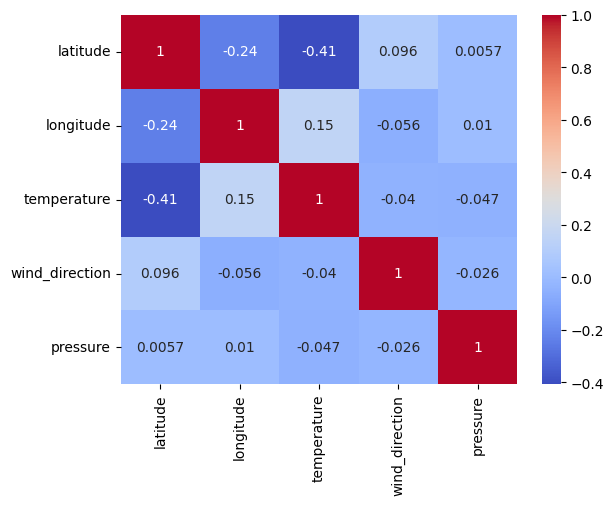

In [29]:
# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()